In colab we need to import the spacy en_core_web_md as a package with !pip install instead of python install on the terminal. After that we need to restart the runtime.

In [1]:
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-2.3.1/en_core_web_md-2.3.1.tar.gz

     |████████████████████████████████| 50.8MB 75kB/s 
     |████████████████████████████████| 10.0MB 2.9MB/s 
     |████████████████████████████████| 2.1MB 33.5MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.3.1-cp36-none-any.whl size=50916643 sha256=29cd5ac914b02de82c3822823dab2a04a120241ada4ce50a8dce4ab2f8871f5b
  Stored in directory: /root/.cache/pip/wheels/6e/65/3a/34cdc26d4084d1d1f1e2ec9914964759ea17aa382c53a57d9f
Successfully built en-core-web-md
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [2]:
import os
import pickle

import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

*Upload submission_db.sqlite3 database*


In [3]:
from google.colab import files 
uploaded = files.upload()

Saving subreddit_db.sqlite3 to subreddit_db.sqlite3


In [4]:
import pandas as pd
import sqlite3
import numpy as np

def refresh_connection_and_cursor():
  try:
    c.close()
    conn.close()
  except: pass
  conn = sqlite3.connect('/content/subreddit_db.sqlite3')
  c = conn.cursor()
  return conn, c

conn, c = refresh_connection_and_cursor()

data = pd.read_sql_query(
    "select * from submission_table order by random() limit 100000;", 
    conn)

c.close()
conn.close()

In [5]:
print(data.shape)
data.head()

(51610, 4)


,subreddit_name,subreddit_id,title,text
0,entertainment,2qh0f,Ellen Page calls out Chris Pratt for attending...,
1,books,2qh4i,School district that has allowed religious gro...,
2,camping,2qk80,took my girlfriend camping for the first time ...,
3,sports,2qgzy,Ballboy's Awesome Catch,
4,funny,2qh33,10 days it is,


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51610 entries, 0 to 51609
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   subreddit_name  51610 non-null  object
 1   subreddit_id    51610 non-null  object
 2   title           51610 non-null  object
 3   text            51610 non-null  object
dtypes: object(4)
memory usage: 1.6+ MB


In [7]:
data['subreddit_name'].unique()

array(['entertainment', 'books', 'camping', 'sports', 'funny', 'movies',
       'PublicFreakout', 'television', 'news', 'DIY', 'AskReddit',
       'gadgets', 'Parenting', 'Fitness', 'socialskills', 'programming',
       'GetMotivated', 'personalfinance', 'Cooking', 'nottheonion',
       'worldnews', 'MachineLearning', 'AdviceAnimals', 'cars', 'space',
       'TwoXChromosomes', 'literature', 'Coronavirus', 'biology',
       'travel', 'HomeImprovement', 'scifi', 'WTF', 'LifeProTips',
       'politics', 'math', 'Health', 'investing', 'Showerthoughts',
       'worldpolitics', 'Documentaries', 'science', 'JusticeServed',
       'mildlyinteresting', 'gaming', 'technology', 'food', 'history',
       'Design', 'Art', 'Music', 'conspiracy', 'announcements'],
      dtype=object)

*Data Wrangling*

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
def warngle(data, text_len_min=100, subreddit_num=50):
  """
  data: dataframe containg the subreddits and their categories
  text_len_min: minimum length of subreddit text required to be analyzed
  statistical trimming:
  subreddit_num: sampled number of subreddit posts in each category
  """
  print("\ndata shape: ", data.shape)

  # converting the title and text columns to string type
  data[['title', 'text']] = data[['title', 'text']].astype('str')
  
  # merge title and text
  data['joint_text'] = data[['title', 'text']].agg(' '.join, axis=1)

  # filter out non word and non space characters.
  # lower case the text and remove extra spaces
  data['joint_text'] = data['joint_text'].str.replace("[^\w\s']",' ').str.lower().apply(lambda row: ' '.join(row.split()))
  # print(data['text'][:10])


  # filter out the rows with no significant subreddit text
  data = data[[len(i)>100 for i in data['joint_text']]]
  print(f"\ndata shape after text length filter: {text_len_min}:")
  print(data.shape)


  # Plot the frequency of subreddit_name in the data set
  subid_count = data['subreddit_id'].value_counts(ascending=False)
  plt.figure(figsize=(12,5))
  # y axis is density plot
  sns.distplot(subid_count, kde=False, bins=len(data['subreddit_id'].value_counts()))
  plt.title('Subreddit category histogram')
  plt.xlabel('#of posts per subreddit category')
  plt.ylabel('# of subreddit categories')


  # filter out the subreddit_ids with low count of posts
  data = data.groupby('subreddit_id').filter(
      lambda x: (x['subreddit_id'].value_counts() > subreddit_num))
  print(f"\ndata shape after dropping low counts subreddit names: {subreddit_num}")
  print(data.shape)


  # Sample a fixed number of posts from each category
  df = data.groupby('subreddit_id', as_index=False).apply(lambda x: x.sample(
      n=subreddit_num, replace=False, random_state=1)).reset_index(level=0, drop=True)
  print(f"\ndf shape after sampling {subreddit_num} posts per subreddit category")
  print(df.shape)
  
  # Number of subreddit categories to classify on
  print(f"\n# of subreddit categories: {len(df['subreddit_id'].value_counts())}")

  return data, df


data shape:  (51610, 4)

data shape after text length filter: 100:
(20918, 5)

data shape after dropping low counts subreddit names: 100
(20368, 5)

df shape after sampling 100 posts per subreddit category
(4400, 5)

# of subreddit categories: 44


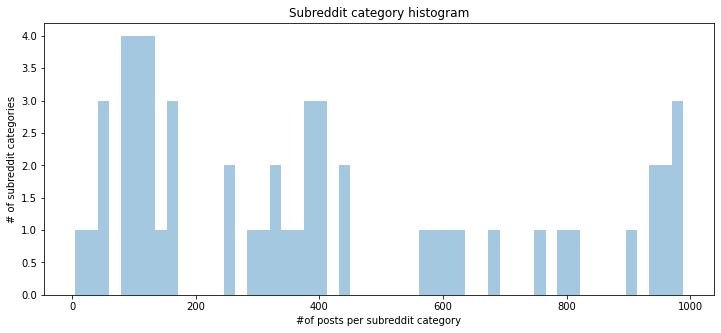

In [10]:
data, df = warngle(data, text_len_min=100, subreddit_num=100);

In [11]:
print(df.shape)
df.sample(n=5, axis=0)
df.head()

(4400, 5)


,subreddit_name,subreddit_id,title,text,joint_text
21635,politics,2cneq,Trump bragged about bringing Michigan 'so many...,,trump bragged about bringing michigan 'so many...
47116,politics,2cneq,Source: Leaked Documents Show the U.S. Governm...,,source leaked documents show the u s governmen...
30561,politics,2cneq,#DeleteFacebook Trends After Report That Mark ...,,deletefacebook trends after report that mark z...
33923,politics,2cneq,Megathread: Robert Mueller has agreed to testi...,Former special counsel Robert S. Mueller III w...,megathread robert mueller has agreed to testif...
35053,politics,2cneq,'The President is afraid of the American peopl...,,'the president is afraid of the american peopl...


In [12]:
df['subreddit_name'].unique()

array(['politics', 'programming', 'sports', 'gaming', 'entertainment',
       'math', 'worldnews', 'technology', 'AskReddit', 'Music', 'scifi',
       'news', 'movies', 'travel', 'books', 'conspiracy', 'history',
       'television', 'Design', 'DIY', 'Cooking', 'space', 'worldpolitics',
       'Health', 'investing', 'cars', 'Documentaries', 'Parenting',
       'biology', 'literature', 'Fitness', 'camping', 'HomeImprovement',
       'personalfinance', 'announcements', 'socialskills',
       'TwoXChromosomes', 'MachineLearning', 'LifeProTips',
       'Showerthoughts', 'JusticeServed', 'Coronavirus', 'PublicFreakout',
       'science'], dtype=object)

### Train and test data

In [13]:
from sklearn.model_selection import train_test_split

#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(df['joint_text'], df['subreddit_name'], 
                                                    test_size=0.2, 
                                                    random_state=110, 
                                                    shuffle=True,
                                                    stratify = df['subreddit_name'])

X_train.shape, y_train.shape

((3520,), (3520,))

## Pipeline of Spacy embedding and various classifiers

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from scipy.stats import randint
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBClassifier

### Classifiers

In [15]:
# NearestNeighbors is the same as the classifier one but unsupervised
knc = KNeighborsClassifier(n_neighbors = 15, radius=1.0, algorithm='auto', 
                           leaf_size=30, metric='minkowski', p=2, n_jobs=7)

In [16]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, 
                               subsample=1.0, criterion='friedman_mse', min_samples_split=2, 
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                               max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, 
                               init=None, random_state=None, max_features=None, verbose=0, 
                               max_leaf_nodes=None, warm_start=False, presort='deprecated', 
                               validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

In [17]:
# XGBoost
# It can handle NaNs
xgbc = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=100, random_state=42,
                  verbosity=1, objective='reg:logistic', booster='gbtree', n_jobs=4,
                  min_split_loss=0, subsample=0.5, sampling_method='uniform',
                  tree_method='auto', num_parallel_tree=1, eval_metric='merror')

### Parameter distributions

In [18]:
# KN Classifier Parameters
algorithm_knc = ['ball_tree', 'kd_tree']
leaf_size_knc = range(30,150,30)
p_knc = [1, 2]

param_dist_knc = {
    'clf__algorithm': algorithm_knc, 
    'clf__leaf_size': leaf_size_knc, 
    'clf__p': p_knc
    }

In [19]:
np.logspace(2, 3, num=5, endpoint=False, base=10).astype(int)
np.arange(5,30,5)

array([ 5, 10, 15, 20, 25])

In [20]:
# Gradient Boost Classifier Parameters
max_features_gbc = np.arange(5,30,5)
max_depth_gbc = range(4,16,4)
min_samples_split_gbc = np.linspace(2, 20, 10, endpoint=True).astype(int)
min_samples_leaf_gbc = np.linspace(2, 20, 10, endpoint=True).astype(int)

param_dist_gbc = {
    'clf__max_features': max_features_gbc, 
    'clf__max_depth': max_depth_gbc, 
    'clf__min_samples_split': min_samples_split_gbc, 
    'clf__min_samples_leaf': min_samples_leaf_gbc,
    }

In [21]:
# XGBC Parameters
colsample_bytree_xgbc = np.arange(0.5,1.01,0.1)
max_depth_xgbc = range(2,16,2)
min_child_weight_xgbc = np.linspace(1, 40, 10, endpoint=True).astype(int)
learning_rate_xgbc = [0.01, 0.1, 0.3]
n_estimators_xgbc = [100, 250, 500]

param_dist_xgbc = {
    'clf__colsample_bytree': colsample_bytree_xgbc, 
    'clf__max_depth': max_depth_xgbc, 
    'clf__min_child_weight': min_child_weight_xgbc, 
    'clf__learning_rate': learning_rate_xgbc,
    'clf__n_estimators': n_estimators_xgbc
    }

### Spacy Embedding

In [22]:
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en.stop_words import STOP_WORDS
#Create the nlp object
nlp = spacy.load("en_core_web_md")

In [23]:
# Spacy embedding
def get_word_vectors(docs):
    if isinstance(docs, str):
      docs = [docs]
    return np.array([nlp(str(doc)).vector for doc in docs])

In [24]:
# Instantiate functiontransformer of the spacy vectorizer
embed = FunctionTransformer(get_word_vectors)

In [25]:
est_dict = {
    'gbc': [gbc, param_dist_gbc],
    'xgbc': [xgbc, param_dist_xgbc],
    'knc': [knc, param_dist_knc]
            }

- When running RandomizedSearchCV with Spacy we may get a error that workers cannot work with unpickled file. We need to set the n_jobs=1 instead of parallel processing.

- To speed up the simulation we can do the Spacy embedding outside of the pipeline and feed the embedded X into the model instead of the text ndarray. Thedrawback is for prediction we woul need to preprocess the input as well to embed the query before passing it to the trained model.


In [26]:
est = {}
for key, value in est_dict.items():
  clfi = value[0]
  # print(clfi, type(clfi))
  param_dist = value[1]
  
  # spacy embedding is taken out of the pipeline to save time in hyperparameter tunning
  pipe = Pipeline([
                   ('emb', embed), 
                   ('clf', clfi)])
  
  est["{0}_est".format(key)] = RandomizedSearchCV(pipe, 
                                                  param_distributions=param_dist, 
                                                  n_iter=4, cv=2, verbose=1)
  
  print('\n', 5*'*',' fitting',key, ' estimator..... ',5*'*')
  est["{0}_est".format(key)].fit(X_train.values, y_train.values)
  print("best params: ",est["{0}_est".format(key)].best_params_)
  print("best score: ",est["{0}_est".format(key)].best_score_)
  print("Test score: ",est["{0}_est".format(key)].score(X_test.values, y_test.values))



 *****  fitting gbc  estimator.....  *****
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 22.0min finished


best params:  {'clf__min_samples_split': 12, 'clf__min_samples_leaf': 18, 'clf__max_features': 15, 'clf__max_depth': 4}
best score:  0.4877840909090909
Test score:  0.5193181818181818

 *****  fitting xgbc  estimator.....  *****
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 21.7min finished


best params:  {'clf__n_estimators': 500, 'clf__min_child_weight': 1, 'clf__max_depth': 14, 'clf__learning_rate': 0.3, 'clf__colsample_bytree': 0.6}
best score:  0.4784090909090909
Test score:  0.5272727272727272

 *****  fitting knc  estimator.....  *****
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 13.1min finished


best params:  {'clf__p': 2, 'clf__leaf_size': 90, 'clf__algorithm': 'ball_tree'}
best score:  0.30113636363636365
Test score:  0.3215909090909091


Baseline Accuracy

In [27]:
baseline = 1/ len(df['subreddit_id'].value_counts())
baseline

0.022727272727272728

In [28]:
print(f"knc best_params: {est['knc_est'].best_params_}, \nbest score: {est['knc_est'].best_score_}\n")
print(f"gbc best_params: {est['gbc_est'].best_params_}, \nbest score: {est['gbc_est'].best_score_}\n")
print(f"xgbc best_params: {est['xgbc_est'].best_params_}, \nbest score: {est['xgbc_est'].best_score_}\n")

knc best_params: {'clf__p': 2, 'clf__leaf_size': 90, 'clf__algorithm': 'ball_tree'}, 
best score: 0.30113636363636365

gbc best_params: {'clf__min_samples_split': 12, 'clf__min_samples_leaf': 18, 'clf__max_features': 15, 'clf__max_depth': 4}, 
best score: 0.4877840909090909

xgbc best_params: {'clf__n_estimators': 500, 'clf__min_child_weight': 1, 'clf__max_depth': 14, 'clf__learning_rate': 0.3, 'clf__colsample_bytree': 0.6}, 
best score: 0.4784090909090909



In [29]:
knc_best = est['knc_est'].best_estimator_


In [30]:
est_dict

{'gbc': [GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                             learning_rate=0.1, loss='deviance', max_depth=3,
                             max_features=None, max_leaf_nodes=None,
                             min_impurity_decrease=0.0, min_impurity_split=None,
                             min_samples_leaf=1, min_samples_split=2,
                             min_weight_fraction_leaf=0.0, n_estimators=100,
                             n_iter_no_change=None, presort='deprecated',
                             random_state=None, subsample=1.0, tol=0.0001,
                             validation_fraction=0.1, verbose=0,
                             warm_start=False),
  {'clf__max_depth': range(4, 16, 4),
   'clf__max_features': array([ 5, 10, 15, 20, 25]),
   'clf__min_samples_leaf': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]),
   'clf__min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])}],
 'knc': [KNeighborsClassifi

*Best estimators (pipeline) after hyper parameter tunning*

In [31]:
est_best = {}
for key in est_dict:
  est_best[key] = est['{0}_est'.format(key)].best_estimator_

In [32]:
# Convert input string to embedded vector
def preprocess(query, vectorize):
  """
  Vectorizes the 'query' string by spacy pretrained model (nlp). 
  the return value serves as a query to the prediction model
  """
  return vectorize(query).reshape(1,-1)

# Accessing the neighbors() method of the KNClassifier of the trained pipeline estimator 
def knneighbors(clf, input, X_train, y_train):
  """
  input: a string type text or vectorized array or an iterable data type
  return: Dataframe of nearest neighbors and their subreddit categories
  """
  results = clf.kneighbors(input)
  neighbors_idx, neighbors_dist = results[1][0], results[0][0]
  neighbors_df = pd.concat([X_train.iloc[neighbors_idx], y_train.iloc[neighbors_idx]], axis=1)
  return neighbors_df

*prediction function to get the list of predicted subreddit categories*

In [33]:
def prediction(model, input, n):
  """
  input: text string or iterable dtype (list, np.array, vectorized array)as input
  model: trained model with predict_proba method
  returns a pandas series containing the the recommended subreddit names
  """
  
  if isinstance(input, str):
    input = [input]
  # probability of each class
  proba = model.predict_proba(input)
  # print(proba.shape)

  # index of the highest probable classes in descending order
  # i[0] is index and i[1] is probability
  index_max = [i[0] for i in sorted(enumerate(proba[0]), key=lambda x:x[1])][::-1]
  
  # Alternative way
  # index_max = proba[0].argsort()[::-1]

  # get the most probable class names
  name = pd.Series(model.classes_[index_max][:n])
  return pd.Series(data= name.to_list(), index = index_max[:n])

**knneighbors() returns the subreddit category of the nearest neighbors to the input query. This is different from prediction() function which predicts the most probable subreddit categories that the query belongs to.**

*Input query*

In [34]:
query = """Does this seem too advanced for first month of kindergarten?
Usually my husband is sitting with my son (working from home, but present) 
during my son's Zoom class but yesterday I did. I was really surprised by 
what the teacher was asking of the kids. My son's teacher wanted the students 
to write stories live during the zoom meeting. She expected them to write full 
sentences with words like "suddenly." She told them if they can't spell the 
words to "sound it out." She kept reminding them to use connecting words to 
transition between topics. The example story she wrote was about 5-6 sentences. 
It was about going to the playground and waiting for her turn on the swings. 
I was pretty surprised because the kids are still learning the alphabet. 
how would they be able to write sentences for before learning letters? Before we 
started school, the principal specifically told families at an info night, 
"Don't worry if your kid doesn't know the alphabet, we'll reach them!" 
So I don't think the teacher has expectations that the kids could already write."""


*Separately embedding the input query allows to access .kneighbors() method of the classifier to get the nearest neighbors for that query*

In [35]:
vect = preprocess(query, get_word_vectors)
neighbors = knneighbors(est_best['knc']['clf'], vect, X_train, y_train)
neighbors

,joint_text,subreddit_name
23420,when a 33 year old dad spends a day in kinderg...,Parenting
7121,lpt at the beginning of every semester make a ...,LifeProTips
30659,update help wife died how to tell my 2yo mummy...,Parenting
10757,me 30m single parent had to console my 10 year...,Parenting
15417,i'm so grateful for my daughter's teacher bein...,Parenting
36205,this is america so i'll pronounce your kid's n...,Parenting
43634,i tried using a school fundraiser to teach my ...,Parenting
29517,i'm being put off maths by the arrogance of ot...,math
45933,i never imagined having a baby would make me h...,Parenting
8112,friendly reminder that ya books are for teenag...,books


*Using preprocess to embed the query string and then calling the prediction function on classifier step of pipeline:*

In [36]:
vect = preprocess(query, get_word_vectors)
preds = prediction(est_best['knc']['clf'], vect, 10)
preds

13          Parenting
31    personalfinance
28               math
27         literature
19              books
16    TwoXChromosomes
10        LifeProTips
43      worldpolitics
42          worldnews
41             travel
dtype: object

*Alternatively we can call the prediction function on pipeline estimator to pass string query instead of embedding*

In [37]:
prediction(est_best['knc'], query, 10)

13          Parenting
31    personalfinance
28               math
27         literature
19              books
16    TwoXChromosomes
10        LifeProTips
43      worldpolitics
42          worldnews
41             travel
dtype: object

## Model Serialization

In [38]:
import pickle

In [39]:
est_best['gbc']

Pipeline(memory=None,
         steps=[('emb',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function get_word_vectors at 0x7f5cd1194d90>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('clf',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=4, max_features=15,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=18,
                                            min_samples_

In [40]:
est_pickle = {}
loaded_pickle ={}

for key in est_dict:
  est_pickle[key] = open(f'{key}_pkl', 'wb')
  pickle.dump(est_best[key], est_pickle[key])

  loaded_pickle[key] = pickle.load(open(f'{key}_pkl', 'rb'))

# pickle the dataframe
X_train.to_pickle("./X_train_pkl")
y_train.to_pickle("./y_train_pkl")

loaded_X_train = pd.read_pickle("./X_train_pkl")
loaded_y_train = pd.read_pickle("./y_train_pkl")

In [41]:
prediction(loaded_pickle['knc'], query, 10)

13          Parenting
31    personalfinance
28               math
27         literature
19              books
16    TwoXChromosomes
10        LifeProTips
43      worldpolitics
42          worldnews
41             travel
dtype: object

## Latent Semantic Indexing (LSI)

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD

In [43]:
# Create Pipeline Components

vect = TfidfVectorizer( stop_words='english', 
                       ngram_range=(1,2),
                       lowercase=True,
                       max_df=0.9,
                       min_df=1,
                       max_features=None)

svd = TruncatedSVD(n_components=100,
                   algorithm='randomized',
                   n_iter=10, random_state=1)

rfc = RandomForestClassifier()

In [44]:
lsi = Pipeline([('vect', vect), ('svd', svd)])
pipe = Pipeline([('lsi', lsi), ('clf', rfc)])

In [45]:
parameters = {
    'lsi__vect__max_df': ( 0.75, 1.0),
    'lsi__vect__min_df': (.02, .05),
    'lsi__vect__max_features': (500, 2000, 5000),
    'lsi__svd__n_components': [50, 250, 500],
    'clf__n_estimators':(5, 10),
    'clf__max_depth':(8, 15, 20)
}

est = GridSearchCV(pipe,parameters, cv=3, n_jobs=7, verbose=1)

In [46]:
est.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   44.7s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  3.1min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  7.1min
[Parallel(n_jobs=7)]: Done 648 out of 648 | elapsed: 10.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('lsi',
                                        Pipeline(memory=None,
                                                 steps=[('vect',
                                                         TfidfVectorizer(analyzer='word',
                                                                         binary=False,
                                                                         decode_error='strict',
                                                                         dtype=<class 'numpy.float64'>,
                                                                         encoding='utf-8',
                                                                         input='content',
                                                                         lowercase=True,
                                                                         max_df=0.9,
             

In [47]:
# The accuracy is less that spacy vectorizer
est.best_score_

0.1897702566694406

In [50]:
est.predict([query])

array(['Parenting'], dtype=object)

In [53]:
prediction(est, query, 10)

13          Parenting
1             Cooking
28               math
8     HomeImprovement
16    TwoXChromosomes
29             movies
6             Fitness
40         television
27         literature
10        LifeProTips
dtype: object

In [54]:
est.best_estimator_

Pipeline(memory=None,
         steps=[('lsi',
                 Pipeline(memory=None,
                          steps=[('vect',
                                  TfidfVectorizer(analyzer='word', binary=False,
                                                  decode_error='strict',
                                                  dtype=<class 'numpy.float64'>,
                                                  encoding='utf-8',
                                                  input='content',
                                                  lowercase=True, max_df=1.0,
                                                  max_features=5000,
                                                  min_df=0.02,
                                                  ngram_range=(1, 2), norm='l2',
                                                  preprocessor=None,
                                                  smooth_idf=True,
                                                  stop_words='english',
    

In [55]:
# pickle grid search model with rfc+lsi
rfclsi = open('rfclsi_pkl', 'wb') 
pickle.dump(est, rfclsi)   

In [56]:
loaded_rfclsi = pickle.load(open('rfclsi_pkl', 'rb'))

In [57]:
prediction(loaded_rfclsi, query, n=10)

13          Parenting
1             Cooking
28               math
8     HomeImprovement
16    TwoXChromosomes
29             movies
6             Fitness
40         television
27         literature
10        LifeProTips
dtype: object